# MPG Data

#### Import required packages.

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as sm
import math
from pandas.stats.api import ols
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
import sklearn.model_selection as m_sel
import plotly.offline as plot
import plotly.graph_objs as go
from sklearn import preprocessing
plot.offline.init_notebook_mode(connected=True)

#### Load Data Files.

In [7]:
data = pd.read_csv('Mpg.csv')

Convert 'Horesepower' column to numeric from string

In [8]:
data.horsepower = pd.to_numeric(data.horsepower, errors=np.NaN)
data.dropna(axis = 0, inplace=True)

Drop car name.

In [9]:
data.drop('carname',axis = 1, inplace=True)

Correlation Matrix

In [10]:
corr = data.corr()
corr

,mpg,cylinders,displacement,horsepower,weight,acceleration,modelyear,origin
mpg,1.000000,-0.777643,-0.804899,-0.778165,-0.832065,0.422188,0.579960,0.564652
cylinders,-0.777643,1.000000,0.950824,0.843315,0.898146,-0.502281,-0.341595,-0.568186
displacement,-0.804899,0.950824,1.000000,0.897265,0.933129,-0.542209,-0.367163,-0.613875
horsepower,-0.778165,0.843315,0.897265,1.000000,0.864397,-0.688857,-0.415239,-0.454509
weight,-0.832065,0.898146,0.933129,0.864397,1.000000,-0.415883,-0.307733,-0.584540
acceleration,0.422188,-0.502281,-0.542209,-0.688857,-0.415883,1.000000,0.286547,0.210975
modelyear,0.579960,-0.341595,-0.367163,-0.415239,-0.307733,0.286547,1.000000,0.179273
origin,0.564652,-0.568186,-0.613875,-0.454509,-0.584540,0.210975,0.179273,1.000000


Correlation Graph.

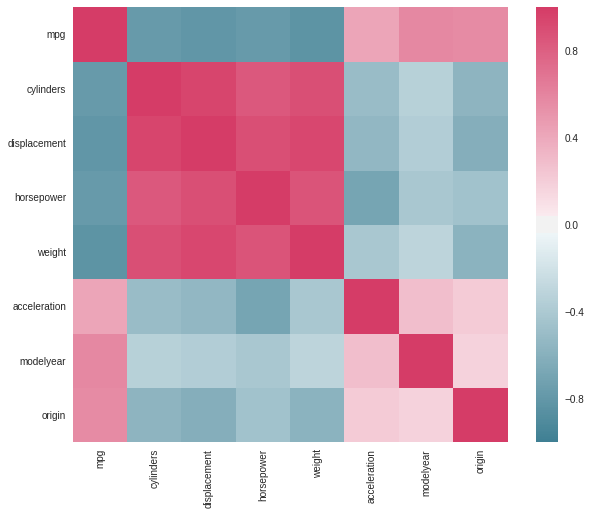

In [11]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 1, as_cmap=True),
            square=True, ax=ax)
plt.show()

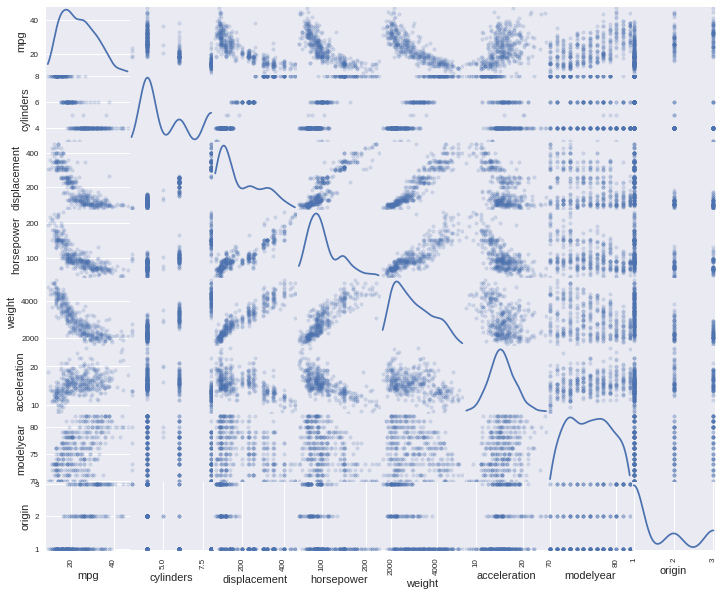

In [12]:
pd.scatter_matrix(data, alpha=.2, figsize=(12,10), diagonal='kde')
plt.show()

Modify Features.

In [13]:
data_mod = data
#data_mod['inv_displacement'] = 1/data_mod.displacement
#data_mod['inv_weight'] = 1/data_mod.weight
#data_mod['inv_horsepower'] = 1/data_mod.horsepower
#data_mod.drop(['displacement', 'horsepower', 'weight'], axis = 1, inplace = True)

Test Data and Training data.

In [14]:
for i in data_mod.columns.tolist():
    data_mod[i] = (data_mod[i] - data_mod[i].mean())/(data_mod[i].var())

In [15]:
X_rl = pd.get_dummies(data_mod).drop('mpg', axis=1)
y_rl = data_mod.mpg
X_train, X_test , Y_train, Y_test = m_sel.train_test_split(X_rl, y_rl, test_size=0.30, random_state=30)

### Linear Regression Model

In [16]:
regr = linear_model.LinearRegression(normalize=True)
regr.fit(X_train, Y_train)
print ('Coefficients : ', regr.coef_) 
print ('\nIntercepts  : ', regr.intercept_)
print ('\nRMSE : ', math.sqrt(np.mean((regr.predict(X_test) - Y_test) ** 2)))

Coefficients :  [ -2.14698699e-02   2.97005614e+00  -2.54753688e-01  -7.63925996e+01
   1.06438152e-02   1.52716929e-01   1.43986309e-02]

Intercepts  :  -0.00274164705626

RMSE :  0.06006590572292217


#### Plots using Plotly.

In [17]:
trace = go.Scatter(
    x=regr.predict(X_test),
    y= Y_test,
    mode='markers',
    name = 'Predicted vs Original',
    line=dict(shape='linear')
)
trace1 = go.Scatter(
    x= Y_test,
    y= Y_test,
    mode='lines',
    name = 'x = y',
    line=dict(shape='linear')
)
data = [trace, trace1]
layout = dict(
    legend=dict(
        traceorder='reversed',
        font=dict(size=16)
    )
)
fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='Scatter plot for Normal Regression')


#### Histogram plot.

In [18]:
data = [go.Histogram(x=((regr.predict(X_test) - Y_test)))]
layout = go.Layout(
    title='Frequency Of Residuals',
    xaxis=dict(
        title='Residuals'
    ),
    yaxis=dict(
        title='Frequency'
    )
)
fig = go.Figure(data=data, layout=layout)
plot.iplot(fig, filename='normalized histogram')

In [19]:
trace0 = go.Box(
    y = (regr.predict(X_test) - Y_test)
)

data = [trace0]

plot.iplot(data)

## RIDGE

In [20]:
alphas = np.logspace(-3,2,200)

In [21]:
ridge = linear_model.Ridge(normalize=True)
coefs = []
mean_errors = []

comn_name1 = X_train.columns.tolist()
comn_name = comn_name1
comn_name.append('alpha')
df = pd.DataFrame(index=list(range(len(alphas))),columns=comn_name)
s = 0

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train,Y_train)
    coefs.append(ridge.coef_)
    pred = ridge.predict(X_test) 
    mean_errors.append(mean_squared_error(Y_test, pred))
    k=0
    while (k < len(comn_name)-1):
        df.loc[s,list(df.columns)[k]] = ridge.coef_[k]
        k = k+1
    df.loc[s,'alpha'] =a    
    s=s+1

In [22]:
comn_name1.pop()

'alpha'

In [ ]:
data = []
for i in comn_name1:
    p = go.Scatter(x= df.alpha, y= df.loc[:,i].tolist(), mode='lines+markers', name=i, hoverinfo='name', line=dict(shape='linear'))
    data.append(p)
        
layout = dict(
    legend=dict(
        
        traceorder='reversed',
        font=dict(size=16)
    )
)
fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='MPG - RIDGE')

In [ ]:
data = []
p = go.Scatter(x= alphas, y=mean_errors, mode='lines+markers', name='Mean Error', hoverinfo='name', line=dict(shape='linear'))
data.append(p)        
layout = dict(
    legend=dict(
        
        traceorder='reversed',
        font=dict(size=16)
    )
)
fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='MPG - MEAN ERROR')








## LASSO

In [220]:
lasso = linear_model.Lasso(max_iter=10000, normalize=True)
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit((X_train), Y_train)
    coefs.append(lasso.coef_)

In [221]:
coefs = np.array(coefs)
np.shape(coefs)

(200, 7)

In [233]:
data = []
for beta in range(len(X_train.columns)):
    trace = go.Scatter(
        x = alphas,
        y = coefs[:,beta],
        mode='lines+markers',
        name = X_train.columns[beta],
        line=dict(shape='linear')
    )
    data.append(trace)


# Edit the layout
layout = dict(
    yaxis = dict(
        range = [-2,1],
    ),
    xaxis = dict(
        range = [0,0.01]
    ),
    legend=dict(
        traceorder='reversed',
        font=dict(size=16)
    ))

fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='weight-alpha-lasso')

In [234]:
lassocv = linear_model.LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_train, Y_train)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, Y_train)
mean_squared_error(Y_test, lasso.predict(X_test))

0.0034828328222618445

In [235]:
pd.Series(lasso.coef_, index=X_test.columns)

cylinders       -0.028965
displacement     4.549054
horsepower      -0.567867
weight         -76.982374
acceleration     0.012891
modelyear        0.161220
origin           0.018016
dtype: float64

## OLS - REGRESSION

In [237]:
ols_result = sm.ols(formula="mpg ~ displacement + weight ", data = data_mod.iloc[:math.floor(len(data_mod)*0.70),:]).fit()
ols_result.params
predict_ols = ols_result.predict(X_test)

ols_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     310.8
Date:                Fri, 31 Mar 2017   Prob (F-statistic):           9.28e-71
Time:                        17:53:00   Log-Likelihood:                 331.43
No. Observations:                 273   AIC:                            -656.9
Df Residuals:                     270   BIC:                            -646.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0034      0.004      0.786      0.433      -0.005       0.012
displacement    -2.5370      1.205     -2.106      0.036      -4.909      -0.165
weight         -72.6345      9.894     -7.341      0.000     -92.113     -53.156
==============================================================================
Omnibus:                       43.661   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.813
Skew:                           0.950   Prob(JB):                     3.10e-15
Kurtosis:                       4.505   Cond. No.                     2.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [238]:
trace = go.Scatter(
    x=predict_ols,
    y= Y_test,
    mode='markers',
    name = 'Predicted vs Original',
    line=dict(shape='linear')
)
trace1 = go.Scatter(
    x= Y_test,
    y= Y_test,
    mode='lines',
    name = 'x = y',
    line=dict(shape='linear')
)
data = [trace, trace1]
layout = dict(
    legend=dict(
        traceorder='reversed',
        font=dict(size=16)
    )
)
fig = dict(data=data, layout=layout)
plot.iplot(fig, filename='Scatter plot for Normal Regression')


## HISTOGRAM

In [239]:
data = [go.Histogram(x=((predict_ols - Y_test)))]
layout = go.Layout(
    title='Frequency Of Residuals',
    xaxis=dict(
        title='Residuals'
    ),
    yaxis=dict(
        title='Frequency'
    )
)
fig = go.Figure(data=data, layout=layout)
plot.iplot(fig, filename='normalized histogram')

### BOXPLOT

In [240]:
trace0 = go.Box(
    y = (predict_ols - Y_test)
)

data = [trace0]

plot.iplot(data)